In [287]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import mne

# NB: add more subjects in the data folder in neurolib package
from neurolib.utils.loadData import Dataset
from neurolib.models.aln import ALNModel

from coonectivity_dynamics import (plot_kuramoto_example,
                                   fast_kuramoto)
from neurolib.utils import functions as func
plt.style.use('seaborn')
# sns.set_style("whitegrid")
sns.set_style("white")
sns.set_context("talk")

In [288]:
ds = Dataset("gw")
ds.Cmat = ds.Cmats[0]
ds.Dmat = ds.Dmats[0]
model = ALNModel(Cmat=ds.Cmat, Dmat=ds.Dmat)

# add custom parameter for downsampling results
# 10 ms sampling steps for saving data, should be multiple of dt
model.params['save_dt'] = 10.0
model.params["tauA"] = 600.0
model.params["sigma_ou"] = 0.0
model.params["b"] = 20.0

model.params["Ke_gl"] = 300.0
model.params["mue_ext_mean"] = 0.2
model.params["mui_ext_mean"] = 0.1

# Sleep model from newest evolution October 2020
model.params["mue_ext_mean"] = 3.3202829454334535
model.params["mui_ext_mean"] = 3.682451894176651
model.params["b"] =  3.2021806735984186
model.params["tauA"] = 4765.3385276559875
model.params["sigma_ou"] = 0.36802952978628106
model.params["Ke_gl"] = 265.48075753153

model.params['dt'] = 0.1
model.params['duration'] = 120 * 1000 #ms
model.params["signalV"] = 80.0

model.run(bold=True)

In [289]:
path = "/Users/valery/Downloads/"

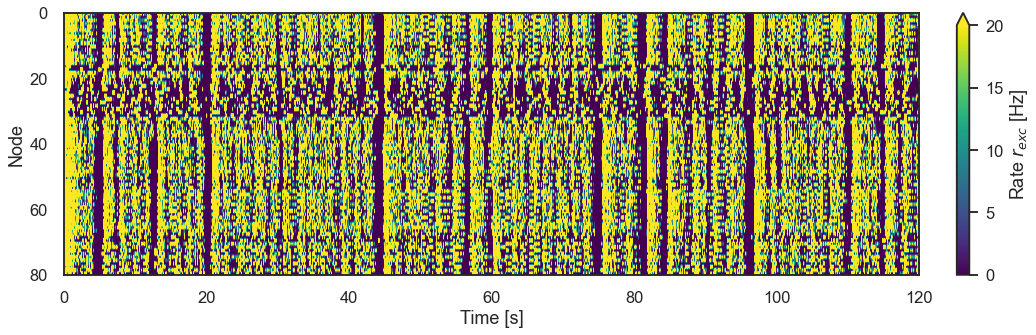

In [290]:
plt.figure(figsize=(15, 5))
plt.imshow(
            model.output, aspect="auto", extent=[0, model.t[-1] / 1000, model.params.N, 0],
            clim=(0, 20), cmap="viridis", 
        )
cbar = plt.colorbar(extend='max', fraction=0.046, pad=0.04)
cbar.set_label("Rate $r_{exc}$ [Hz]")
plt.ylabel("Node")
plt.xlabel("Time [s]")
plt.tight_layout()
plt.savefig(path + "sleep_ts.png", dpi=100)

# PLV

In [291]:
%%time
data = model.rates_exc

# sfreq = 1000 ??
con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(
    np.split(data, 12, axis=1), method='plv', 
    sfreq=10000, fmin=(0, 4, 8, 13, 30),
    fmax=(4, 8, 12, 30, 70), faverage=True)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3160 connections
    using t=0.000s..10.000s for estimation (100000 points)
    computing connectivity for the bands:
     band 1: 0.0Hz..4.0Hz (41 points)
     band 2: 4.0Hz..8.0Hz (41 points)
     band 3: 8.0Hz..12.0Hz (41 points)
     band 4: 13.0Hz..30.0Hz (171 points)
     band 5: 30.0Hz..70.0Hz (401 points)
    connectivity scores will be averaged for each band
/opt/anaconda3/envs/neurolib/lib/python3.7/site-packages/mne/connectivity/spectral.py:1010: RuntimeWarning: divide by zero encountered in double_scalars
  5. / np.min(fmin), five_cycle_freq))
<timed exec>:7: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 10.000 sec, need at least inf sec epochs or fmin=0.500. Spectrum estimate will be unreliable.
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLV
    computing connectivit

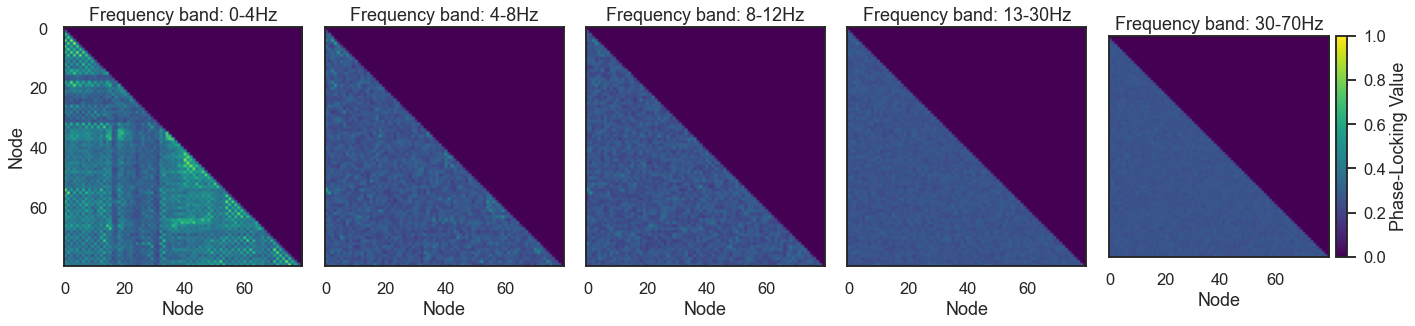

In [292]:
fig, ax = plt.subplots(1, 5, figsize=(20, 10), sharey=True)


for i, (_ax, freq_label) in enumerate(zip(ax, ("0-4Hz", "4-8Hz", "8-12Hz", "13-30Hz", "30-70Hz"))):
    im = _ax.imshow(con[:,:,i], clim=(0, 1), cmap="viridis")
    _ax.set_title(f'Frequency band: {freq_label}')
    if i == 0:
        _ax.set_ylabel("Node")
    _ax.set_xlabel("Node")
    plt.tight_layout()

divider = make_axes_locatable(_ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Phase-Locking Value")
plt.tight_layout()
plt.savefig(path + "plv_freq_bands.png", dpi=100)


# Kuramoto

In [293]:
# %%time
# mkur = np.zeros((80, 80))
# stdkur = np.zeros((80, 80))
# 
# for i, j in zip(np.tril_indices(80)[0], np.tril_indices(80)[1]):
#     kur = fast_kuramoto(np.array([data[i, :200_000], data[j, :200_000]]))
#     mkur[i, j] = kur.mean()
#     stdkur[i, j] = kur.std()


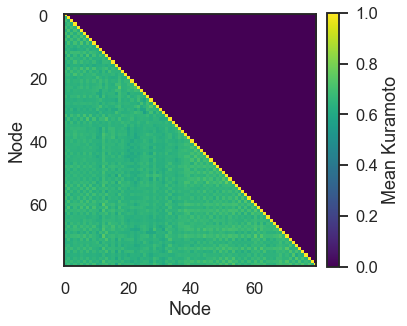

In [294]:
plt.figure(figsize=(6, 6))
plt.imshow(mkur, clim=(0, 1), cmap="viridis")
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Mean Kuramoto")
plt.ylabel("Node")
plt.xlabel("Node")
plt.tight_layout()
plt.savefig(path + "mean_kuramoto.png", dpi=100)

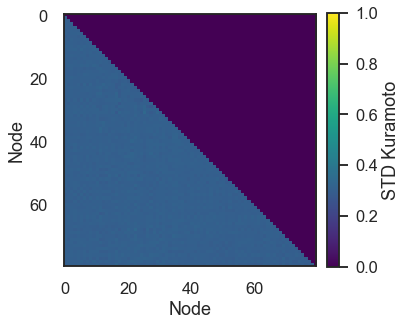

In [295]:
plt.figure(figsize=(6, 6))
plt.imshow(stdkur, clim=(0, 1), cmap="viridis")
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("STD Kuramoto")
plt.ylabel("Node")
plt.xlabel("Node")
plt.tight_layout()
plt.savefig(path + "std_kuramoto.png", dpi=100)

# DTW

In [296]:
from fastdtw import fastdtw

In [297]:
%%time
data = model.rates_exc
dtw = np.zeros((80, 80))

for i, j in zip(np.tril_indices(80)[0], np.tril_indices(80)[1]):
    distance, _ = fastdtw(data[i, ::100][:10_000], data[j, ::100][:10_000])
    dtw[i, j] = distance

CPU times: user 1min 59s, sys: 280 ms, total: 2min
Wall time: 2min


In [298]:
dtw_norm = 1 - dtw/dtw.max()
dtw_norm[np.triu_indices(80)] = dtw_norm.T[np.triu_indices(80)]

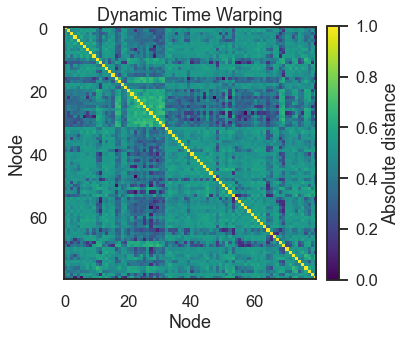

In [299]:
plt.figure(figsize=(6, 6))
plt.imshow(dtw_norm, clim=(0, 1), cmap="viridis")
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Absolute distance")
plt.ylabel("Node")
plt.xlabel("Node")
plt.title("Dynamic Time Warping")
plt.tight_layout()
plt.savefig(path + "dtw_norm.png", dpi=100)

# FC

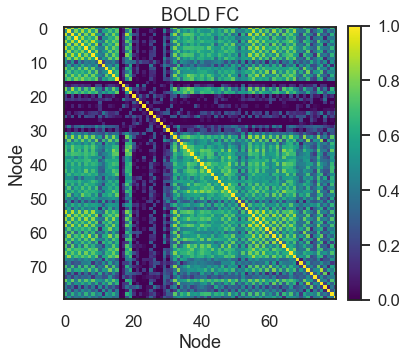

In [300]:
plt.figure(figsize=(6, 6))
plt.imshow(func.fc(model.BOLD.BOLD[:, 10:]), clim=(0, 1), cmap="viridis")
cbar = plt.colorbar(fraction=0.046, pad=0.04)
# cbar.set_label("Absolute distance")
plt.ylabel("Node")
plt.xlabel("Node")
plt.title("BOLD FC")
plt.tight_layout()
plt.savefig(path + "bold_fc.png", dpi=100)

# States

In [301]:
import brainplot as bp
from neurolib.utils import atlases
atlas = atlases.AutomatedAnatomicalParcellation2()

states = bp.detectSWs(model, filter_long=True)

#involvement =  1 - np.sum(states, axis=0) / states.shape[0]
involvement = bp.get_involvement(states)

 # Involvment
 SEE: https://github.com/caglarcakan/sleeping_brain/blob/main/notebooks/RESULT-sleep-model.ipynb

In [302]:
import xarray as xr
from neurolib.utils.signal import Signal

inv_xr = xr.DataArray(involvement, coords=[model.t], dims=[ "time"])
sig = Signal(inv_xr, time_in_ms=True)

def get_phase(signal, filter_args, pad=None):
    """
    Extract phase of the signal. Steps: detrend -> pad -> filter -> Hilbert
    transform -> get phase -> un-pad.
    :param signal: signal to get phase from
    :type signal: `neuro_signal.Signal`
    :param filter_args: arguments for `Signal`'s filter method (see its
        docstring)
    :type filter_args: dict
    :param pad: how many seconds to pad, if None, won't pad
    :type pad: float|None
    :return: wrapped Hilbert phase of the signal
    :rtype: `neuro_signal.Signal`
    """
    assert isinstance(signal, Signal)
    phase = signal.detrend(inplace=False)
    if pad:
        phase.pad(
            how_much=pad, in_seconds=True, padding_type="reflect", side="both"
        )
    phase.filter(**filter_args)
    phase.hilbert_transform(return_as="phase_wrapped")
    if pad:
        phase.sel([phase.start_time + pad, phase.end_time - pad])
    return phase

phase = get_phase(sig, filter_args={"low_freq": 0.5, "high_freq": 2})
node_mean_phases_down, node_mean_phases_up = bp.get_transition_phases(states, phase.data)
node_mean_phases_down = np.array(node_mean_phases_down)
node_mean_phases_up = np.array(node_mean_phases_up)

Setting up band-pass filter from 0.5 - 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 2.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filter length: 66001 samples (6.600 sec)

Node 0: mean_down_phase = -1.1624360550631525, mean_up_phase = 1.2656933633171779
Node 1: mean_down_phase = -1.2977155172912358, mean_up_phase = 1.1917449073606523
Node 2: mean_down_phase = -1.1067560919810333, mean_up_phase = 1.1339958301729194
Node 3: mean_down_phase = -1.1545472727960966, mean_up_phase = 0.9506635764092213
Node 4: mean_down_phase = -1.0377419676946795, mean_up_phase = 1.4075990961706832
Node 5: mean_down_phase = -1.2755375187153992, mean_up_phase = 0.96555

In [303]:
# modulo all up phases with positive pi, and vice versa
if np.any(node_mean_phases_up<0) or np.any(node_mean_phases_down>0):
    print("Modulo was necessary")
node_mean_phases_up= np.mod(node_mean_phases_up, np.pi)
node_mean_phases_down = np.mod(node_mean_phases_down, -np.pi)

Modulo was necessary


# Correlations

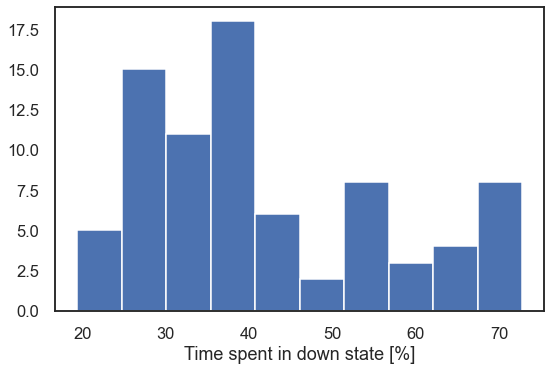

In [304]:
mean_states =  np.mean(states, axis=1) #  * 1000
len_states = np.sum(states, axis=1) * model.params.dt / 1000

normalized_down_lengths = model.params.duration / 1000 - len_states
normalized_down_lengths = normalized_down_lengths / (model.params.duration / 1000) * 100 # to percent
plt.hist(normalized_down_lengths)
plt.xlabel('Time spent in down state [%]')
plt.tight_layout()
plt.savefig(path + "time_spent_in_down.png")


In [305]:
normalized_down_lengths = 1 - normalized_down_lengths/100

In [306]:
from connectivity import (plot_graph_circos, make_graph, 
                          graph_measures, z_scores,
                          similarity_between_subjects, is_symmetric)

columns = ['mean_degree', 'degree', 'closeness', 'betweenness',
           'mean_shortest_path', 'neighbor_degree', 'neighbor_degree_new', 'clustering_coefficient', 'omega', 'sigma',
           'mean_clustering_coefficient', 'backbone', 'Cmat', 'Dmat']
df = pd.DataFrame(columns=columns)


G = make_graph(ds.Cmat)
G, gm = graph_measures(G) # , dmat
df.loc[0] = gm

results_sc =  pd.DataFrame(df.loc[0, ['degree', 'closeness', 'betweenness', 'neighbor_degree_new', 'clustering_coefficient']].to_dict())
results_sc.columns = ['degree_sc', 'closeness_sc', 'betweenness_sc', 'neighbor_sc', 'clustering_sc']

df = pd.DataFrame(columns=columns)

fc = func.fc(model.BOLD.BOLD[:, 10:])
fc[fc<0] = 0
G = make_graph(fc)
G, gm = graph_measures(G) # , dmat
df.loc[0] = gm
results_fc =  pd.DataFrame(df.loc[0, ['degree', 'closeness', 'betweenness', 'neighbor_degree_new', 'clustering_coefficient']].to_dict())
results_fc.columns = ['degree_fc', 'closeness_fc', 'betweenness_fc', 'neighbor_fc', 'clustering_fc']


results = pd.concat([results_sc, results_fc], axis=1)

for i, freq in enumerate(["0-4Hz", "4-8Hz", "8-12Hz", "13-30Hz", "30-70Hz"]):
    G = make_graph(con[:,:,i])
    G, gm = graph_measures(G) # , dmat
    df = pd.DataFrame(columns=columns)
    df.loc[0] = gm
    results_plv =  pd.DataFrame(df.loc[0, ['degree', ]].to_dict())
    results_plv.columns = [f'degree_plv_{freq}']
    results = pd.concat([results, results_plv], axis=1)

G = make_graph(dtw_norm)
G, gm = graph_measures(G) # , dmat
df = pd.DataFrame(columns=columns)
df.loc[0] = gm
results_dtw =  pd.DataFrame(df.loc[0, ['degree', ]].to_dict())
results_dtw.columns = [f'degree_dtw']
results = pd.concat([results, results_dtw], axis=1)

/Users/valery/NEUROLIB/NI-project/connectivity/connectivity.py:213: RuntimeWarning: invalid value encountered in true_divide
  N = neighborhoods / np.sum(neighborhoods, axis=0)


In [307]:
results.loc[:, 'time_up'] = normalized_down_lengths
results.loc[:, 'phases_up'] = node_mean_phases_up
results.loc[:, 'phases_down'] = node_mean_phases_down

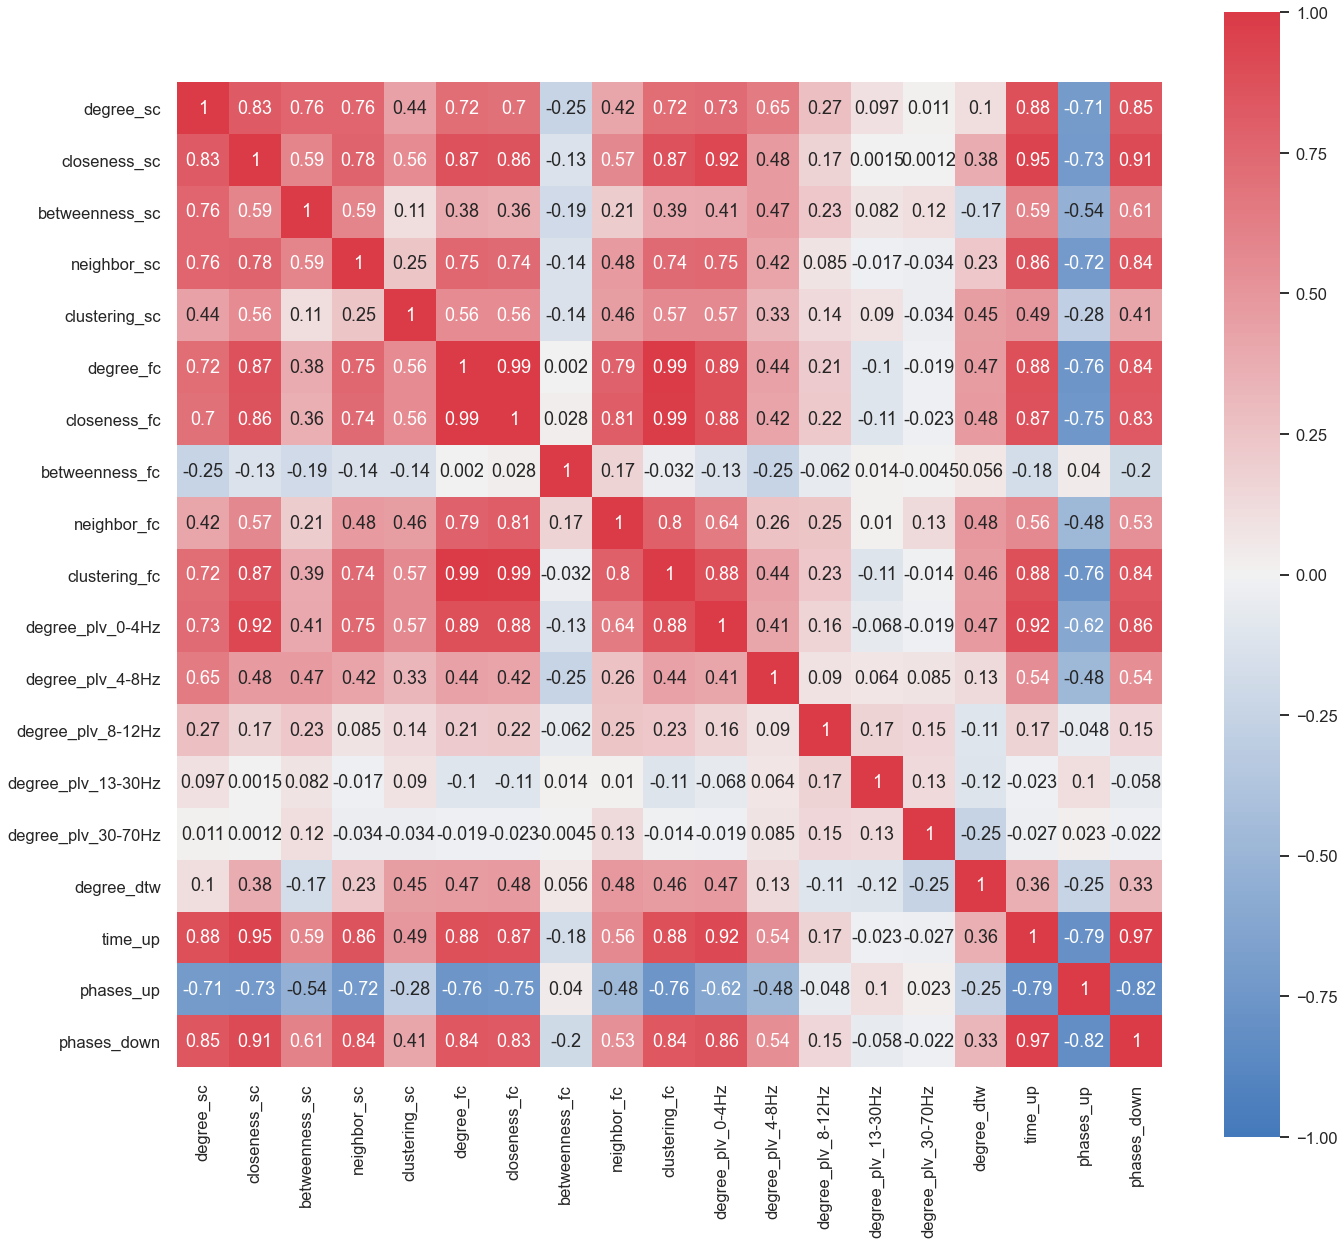

In [308]:
corr = results.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(250, 10, as_cmap=True)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 18))
    ax = sns.heatmap(corr, cmap=cmap, #  mask=mask,
                     vmax=1., vmin=-1., square=True, annot=True)
    # plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig(path + "correlations.png")

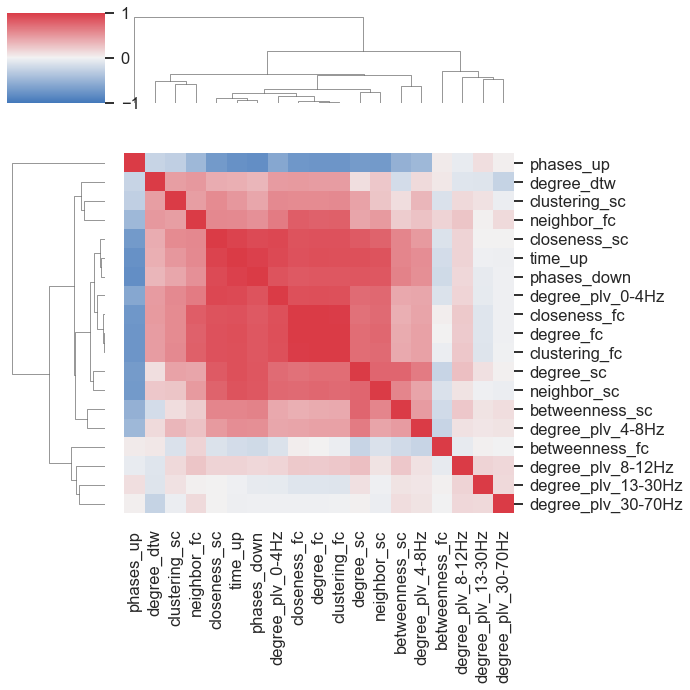

In [309]:
sns.clustermap(corr, cmap=cmap, vmax=1., vmin=-1.)
plt.tight_layout()
plt.savefig(path + "correlations_clustes.png")

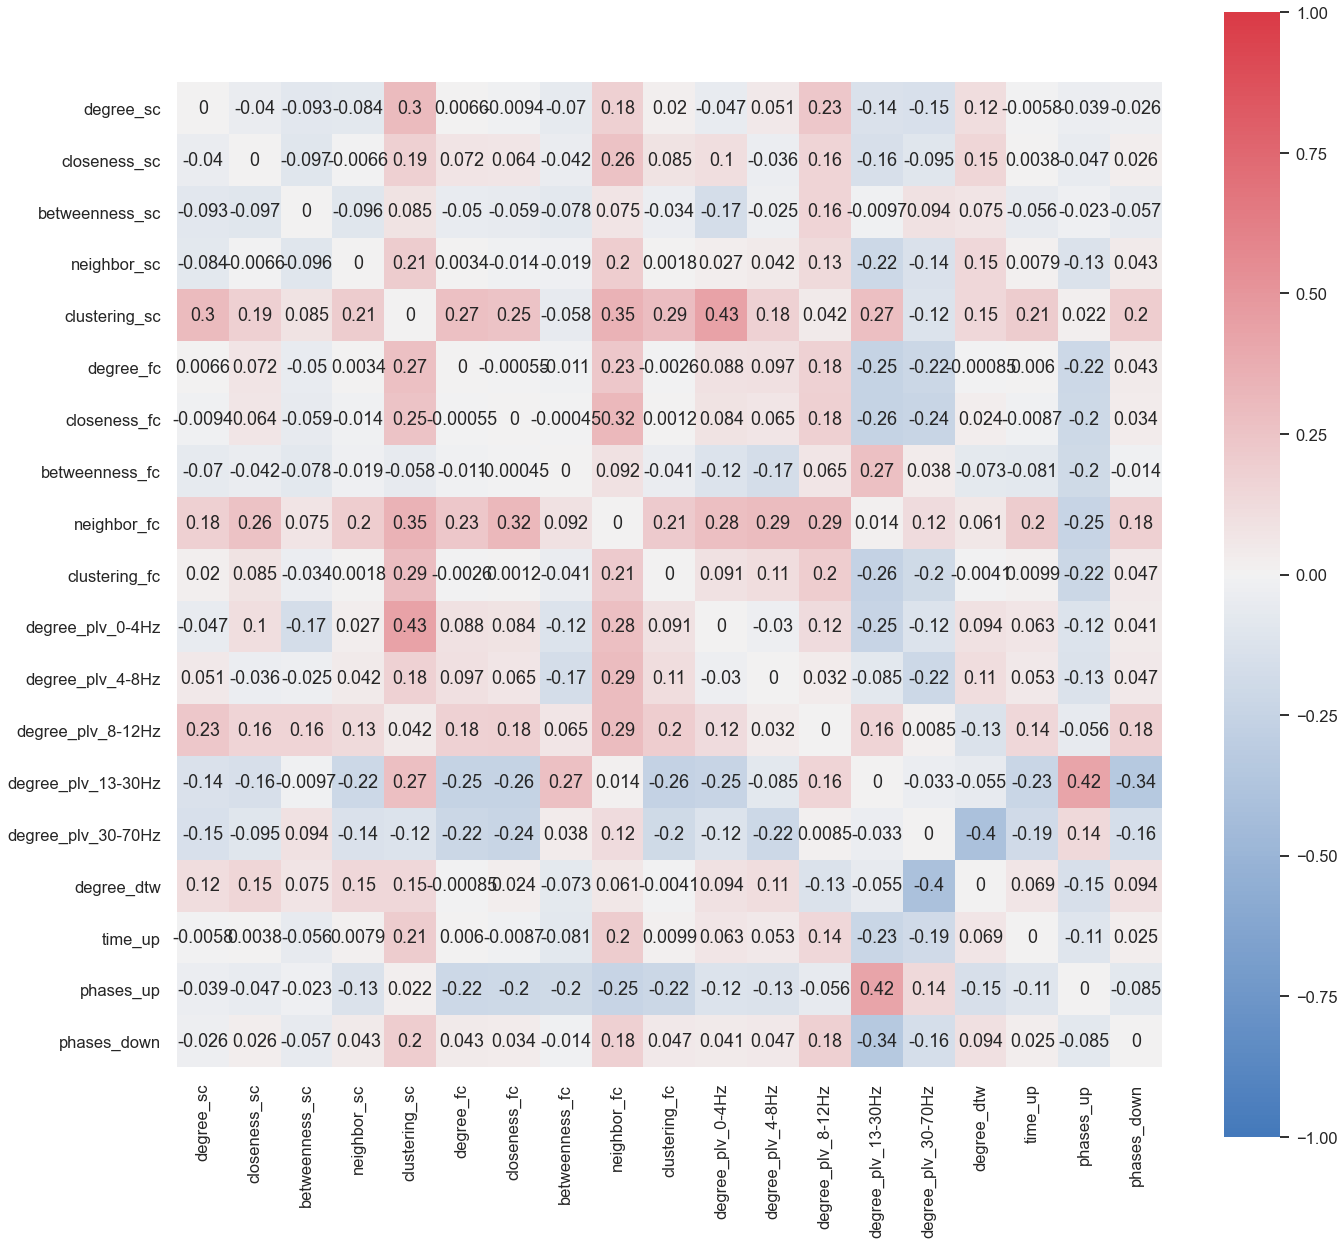

In [310]:
corr = corr - corr_mean
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(250, 10, as_cmap=True)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 18))
    ax = sns.heatmap(corr, cmap=cmap, #  mask=mask,
                     vmax=1., vmin=-1., square=True, annot=True)
    # plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig(path + "correlations_mean.png")

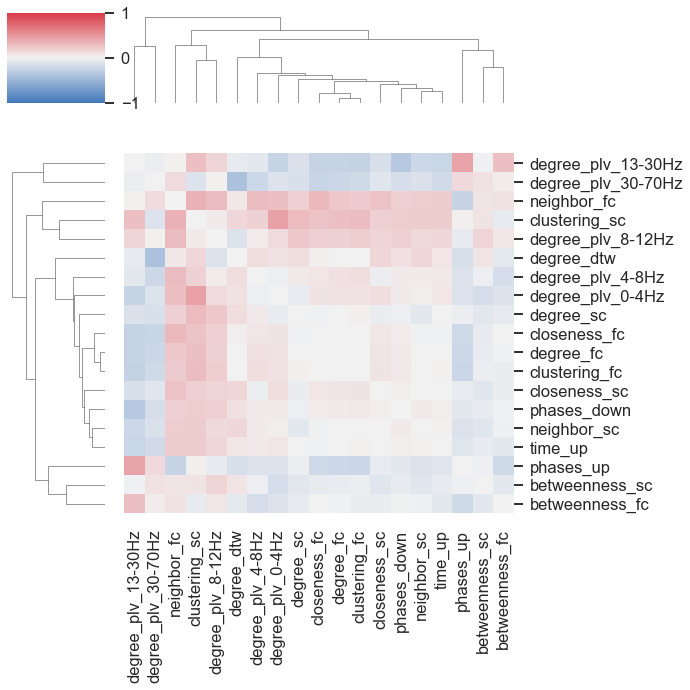

In [312]:
sns.clustermap(corr, cmap=cmap, vmax=1., vmin=-1.)
plt.tight_layout()
plt.savefig(path + "correlations_clustes_mean.png")

In [311]:
# corr_mean = corr.copy()